# Online Product Sales
Predict  online sales of a consumer product based on a set of data relating to product characteristics.

## Description
&emsp;
We aim to predict the monthly online sales of a product, knowing that products are online self-help programs following an initial advertising campaign.
<br><br>&emsp;
Machine learning is ideal for tackling prediction problems, so we will treat our problem as a multiple output regression problem that will predict sales over the first 12 months following the product launch. Our goal will therefore be to build a model to predict the monthly online sales of a product.

## Data

- Our data is in CSV (comma separated values) format. Each row in this dataset represents a different consumer product.
- The first 12 columns (Outcome M1 to Outcome M12) contain monthly online sales for the first 12 months following product launch.
- Date_1 is the number of the day when the major advertising campaign started and the product was launched.
- Date_2 is the number of the day when the product was announced and an advertising campaign was launched before the product was released.
- The other columns of the data set are the characteristics of the product and the advertising campaign. Quan_x are quantitative variables and Cat_x are categorical variables.

## Assessment

&emsp;
To measure the performance of the model, we will use as an evaluation measure the root mean square logarithmic error (RMSLE) over all 12 prediction columns. Our model will have to minimize this error

## Importation des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv("online-sales/TrainingDataset.csv")
test = pd.read_csv("online-sales/TestDataset.csv")

## Exploratory Data Analysis

We will proceed to the analysis of our dataframe.

In [3]:
train.shape

(751, 558)

Our dataframe contains 751 observations and 558 different variables.

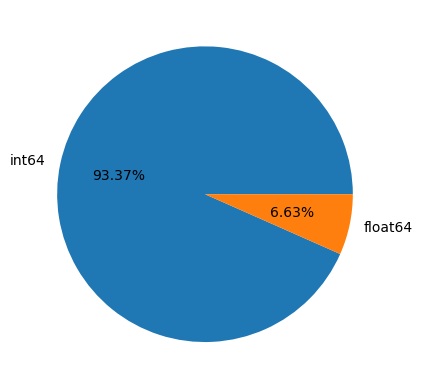

In [4]:
train.dtypes.value_counts().plot.pie(autopct="%.2f%%");

Our variables are mainly 93.37% discrete variables.

In [5]:
date_cols = train.columns[train.columns.str.contains("Date")]
quan_cols = train.columns[train.columns.str.contains("Quan")]
out_cols  = train.columns[train.columns.str.contains("Out")]
cat_cols  = train.columns[train.columns.str.contains("Cat")]

In [6]:
pd.DataFrame({
    "Date": date_cols.shape,
    "Quantitative": quan_cols.shape,
    "Categorical": cat_cols.shape,
    "Outcome": out_cols.shape
}, index=["Count"]).T

Count
Date              2
Quantitative     31
Categorical     513
Outcome          12

Among the 558 variables, 2 represent dates, 31 are quantitative variables, 513 are categorical variables and the remaining 12 are targets.

In [7]:
missings = train.isna().sum() / len(train)
missings[missings > 0].sort_values().rename("Missing[%]").to_frame()

Missing[%]
Outcome_M2     0.003995
Date_2         0.003995
Outcome_M3     0.006658
Outcome_M4     0.006658
Quan_3         0.006658
Quan_15        0.014647
Quan_2         0.015979
Outcome_M5     0.031957
Outcome_M6     0.061252
Outcome_M7     0.075899
Outcome_M8     0.085220
Outcome_M9     0.098535
Quan_4         0.105193
Outcome_M10    0.126498
Outcome_M11    0.141145
Outcome_M12    0.149134
Quan_16        0.410120
Quan_17        0.435419
Quant_24       0.541944
Quant_25       0.583222
Quan_10        0.631158
Quan_9         0.631158
Quan_5         0.631158
Quan_6         0.631158
Quan_7         0.631158
Quan_8         0.631158
Quan_13        0.631158
Quan_12        0.631158
Quan_11        0.631158
Quan_14        0.631158
Quan_19        0.750999
Quan_21        0.852197
Quant_23       0.888149
Quant_22       0.904128
Quan_18        0.906791
Quan_20        0.941411
Quan_22        0.978695

We observe several variables with missing values. Some of them have only a handful of missing values, while the others are mostly empty. The target variables also contain missing values.

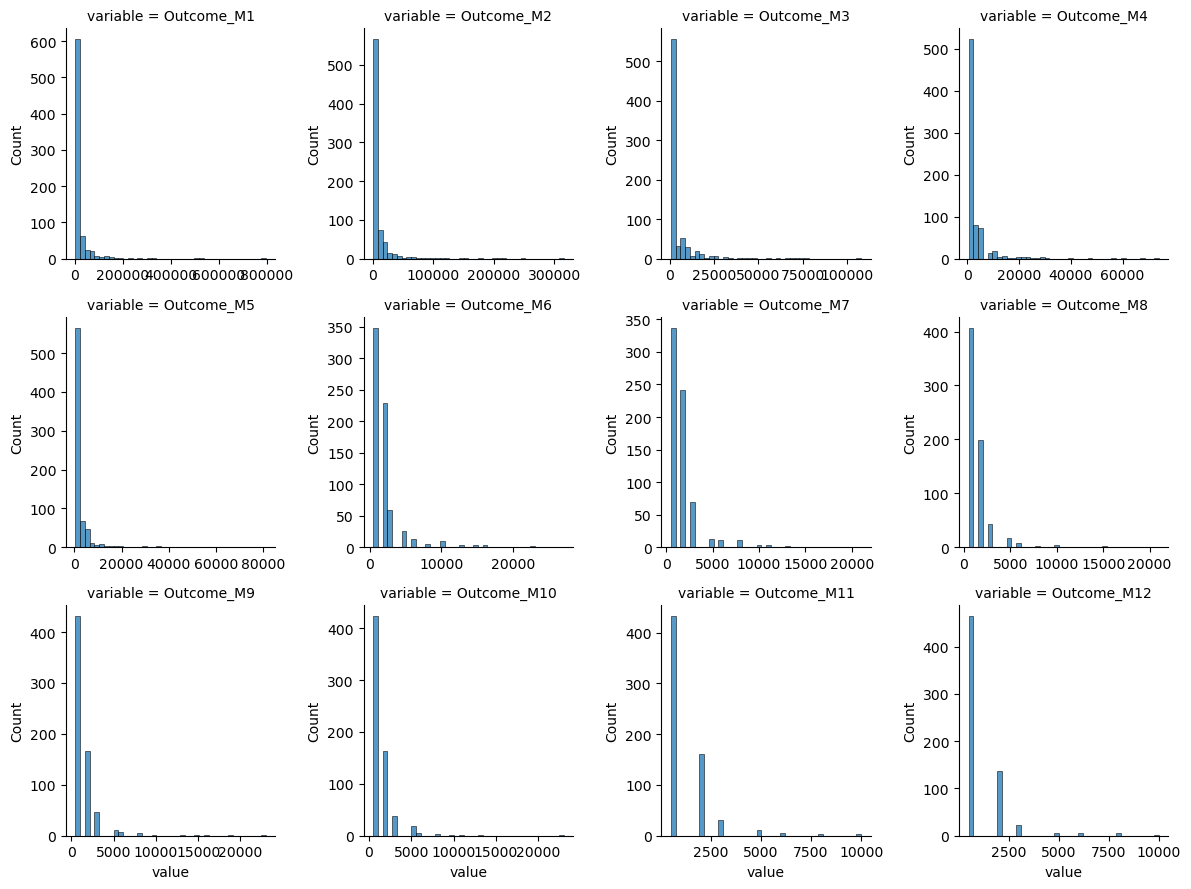

In [9]:
sns.FacetGrid(
    data=train.melt(value_vars=out_cols),
    col="variable",
    col_wrap=4,
    sharex=False,
    sharey=False
).map(sns.histplot, "value", bins=40);

Above, we observe the distributions of the target variables. Note that these variables are right skewed.

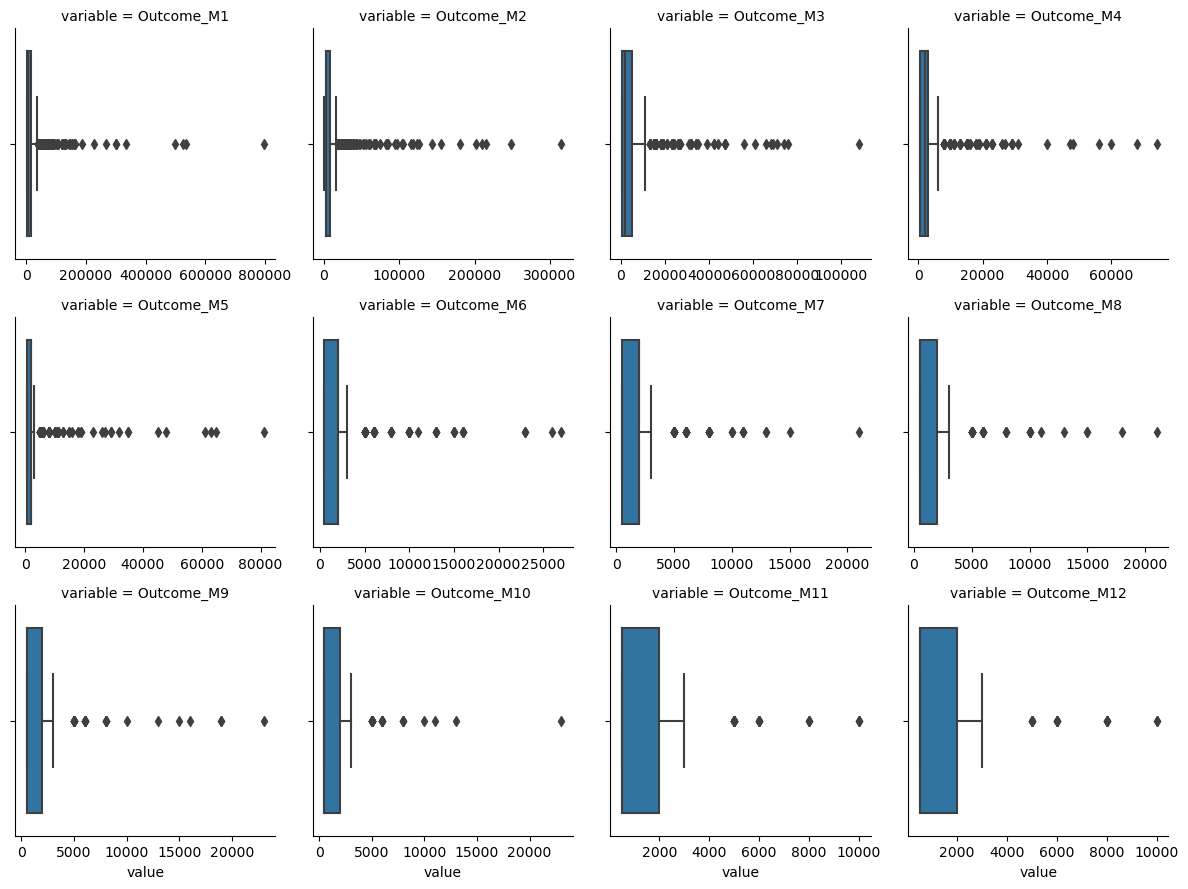

In [10]:
sns.FacetGrid(
    data=train.melt(value_vars=out_cols),
    col="variable",
    col_wrap=4,
    sharex=False,
    sharey=False
).map(sns.boxplot, "value");

By observing the box plots, we can highlight the outliers and we see that the first months contain more outliers.

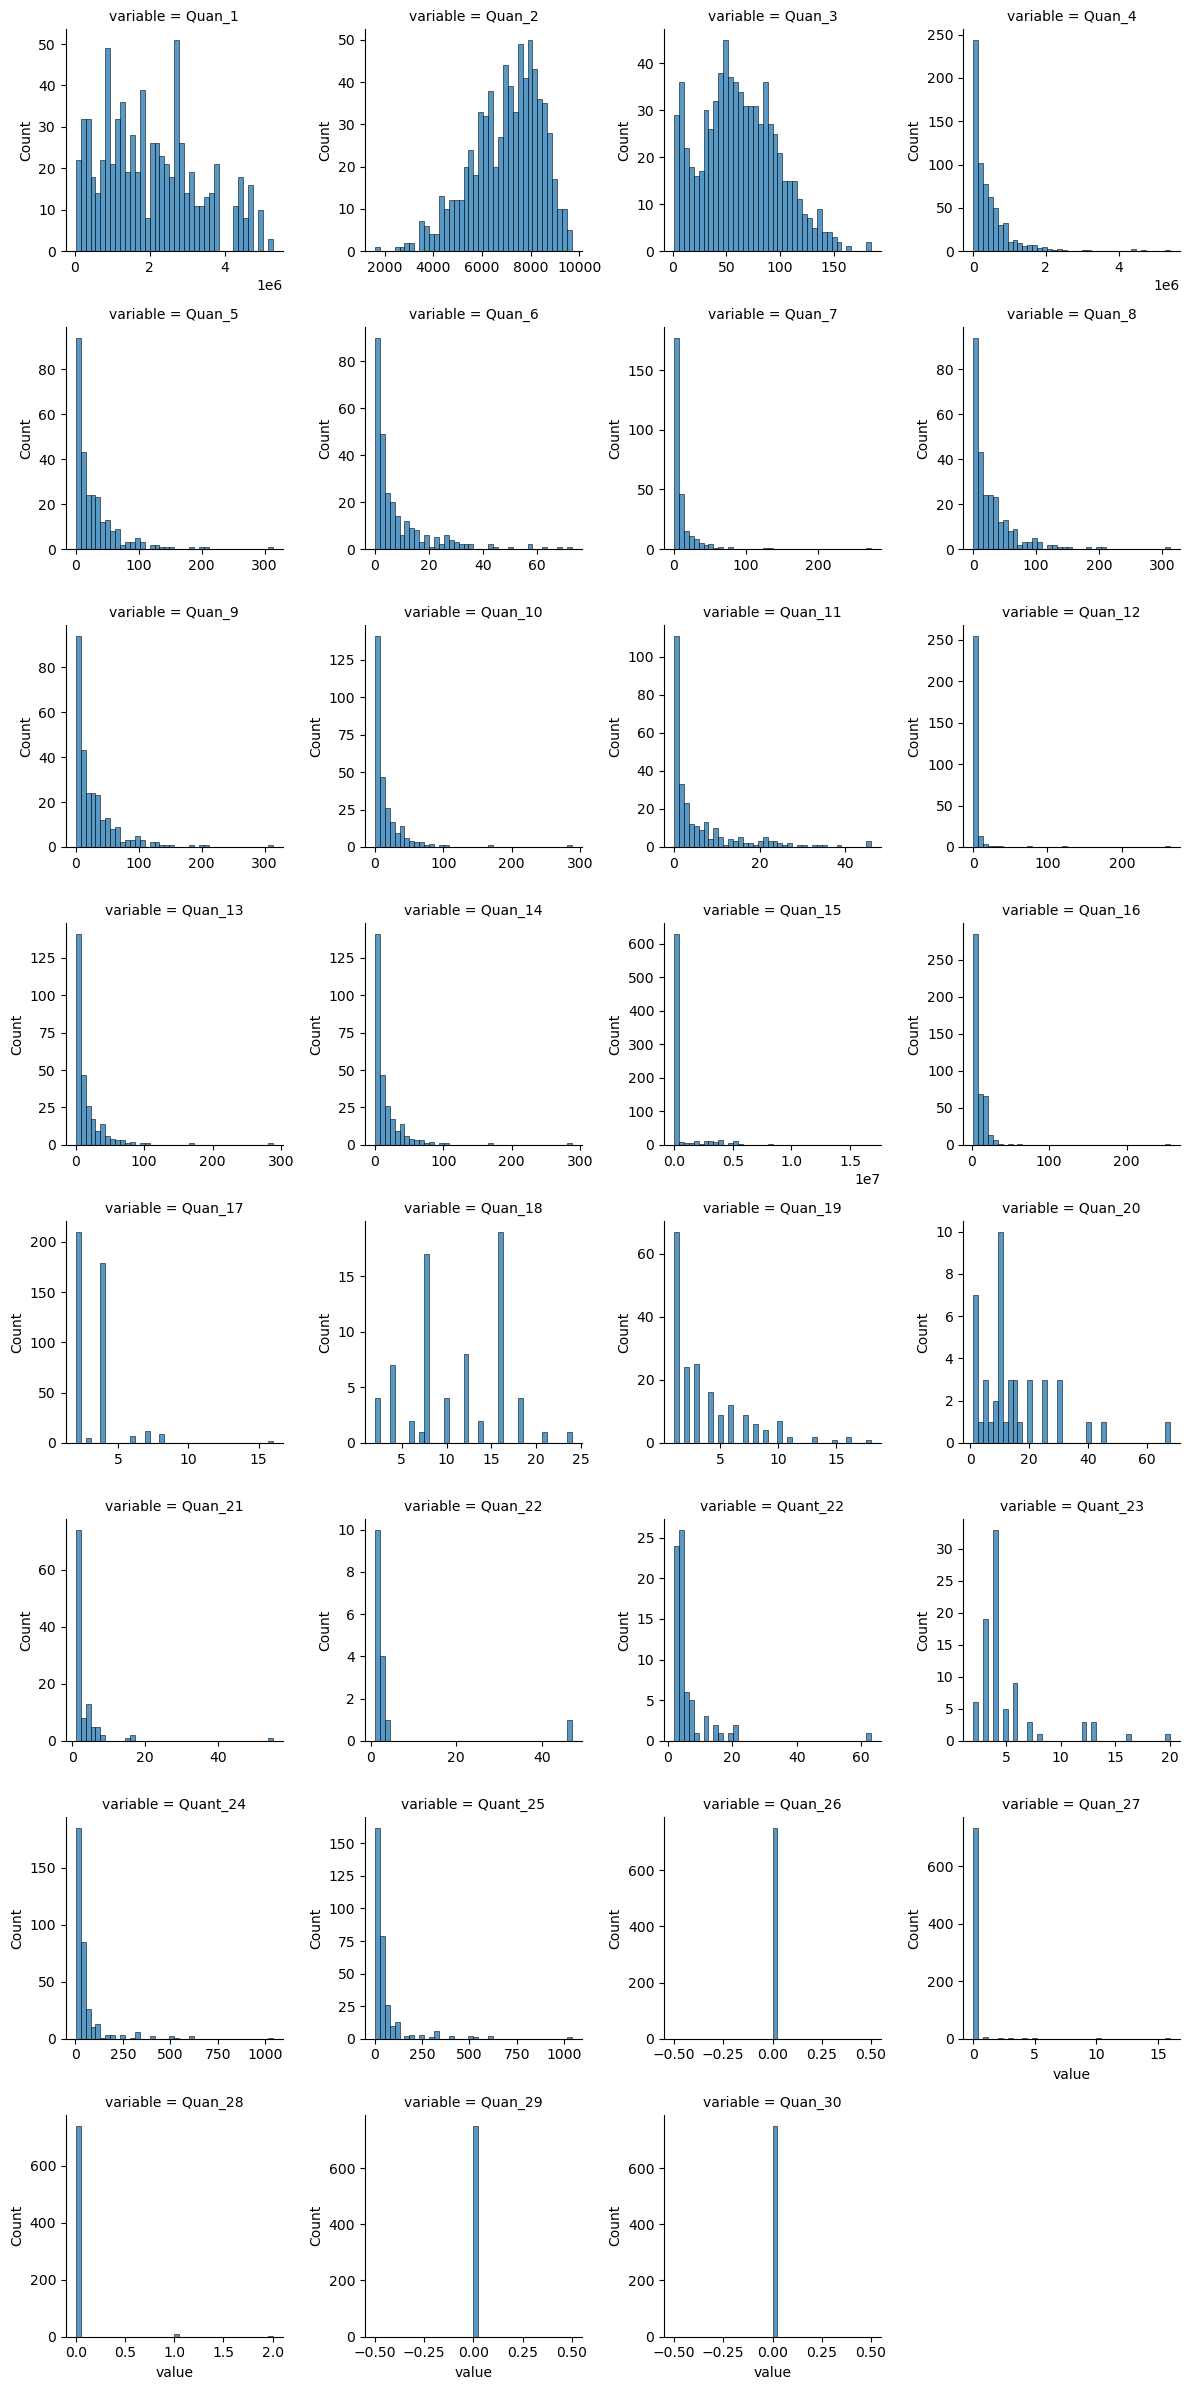

In [11]:
sns.FacetGrid(
    data=train.melt(value_vars=quan_cols),
    col="variable",
    col_wrap=4,
    sharex=False,
    sharey=False
).map(sns.histplot, "value", bins=40);

Above, we look at the distribution of quantitative variables and note that among them, some are constant while most are skewed, with a large proportion being strongly right-skewed.

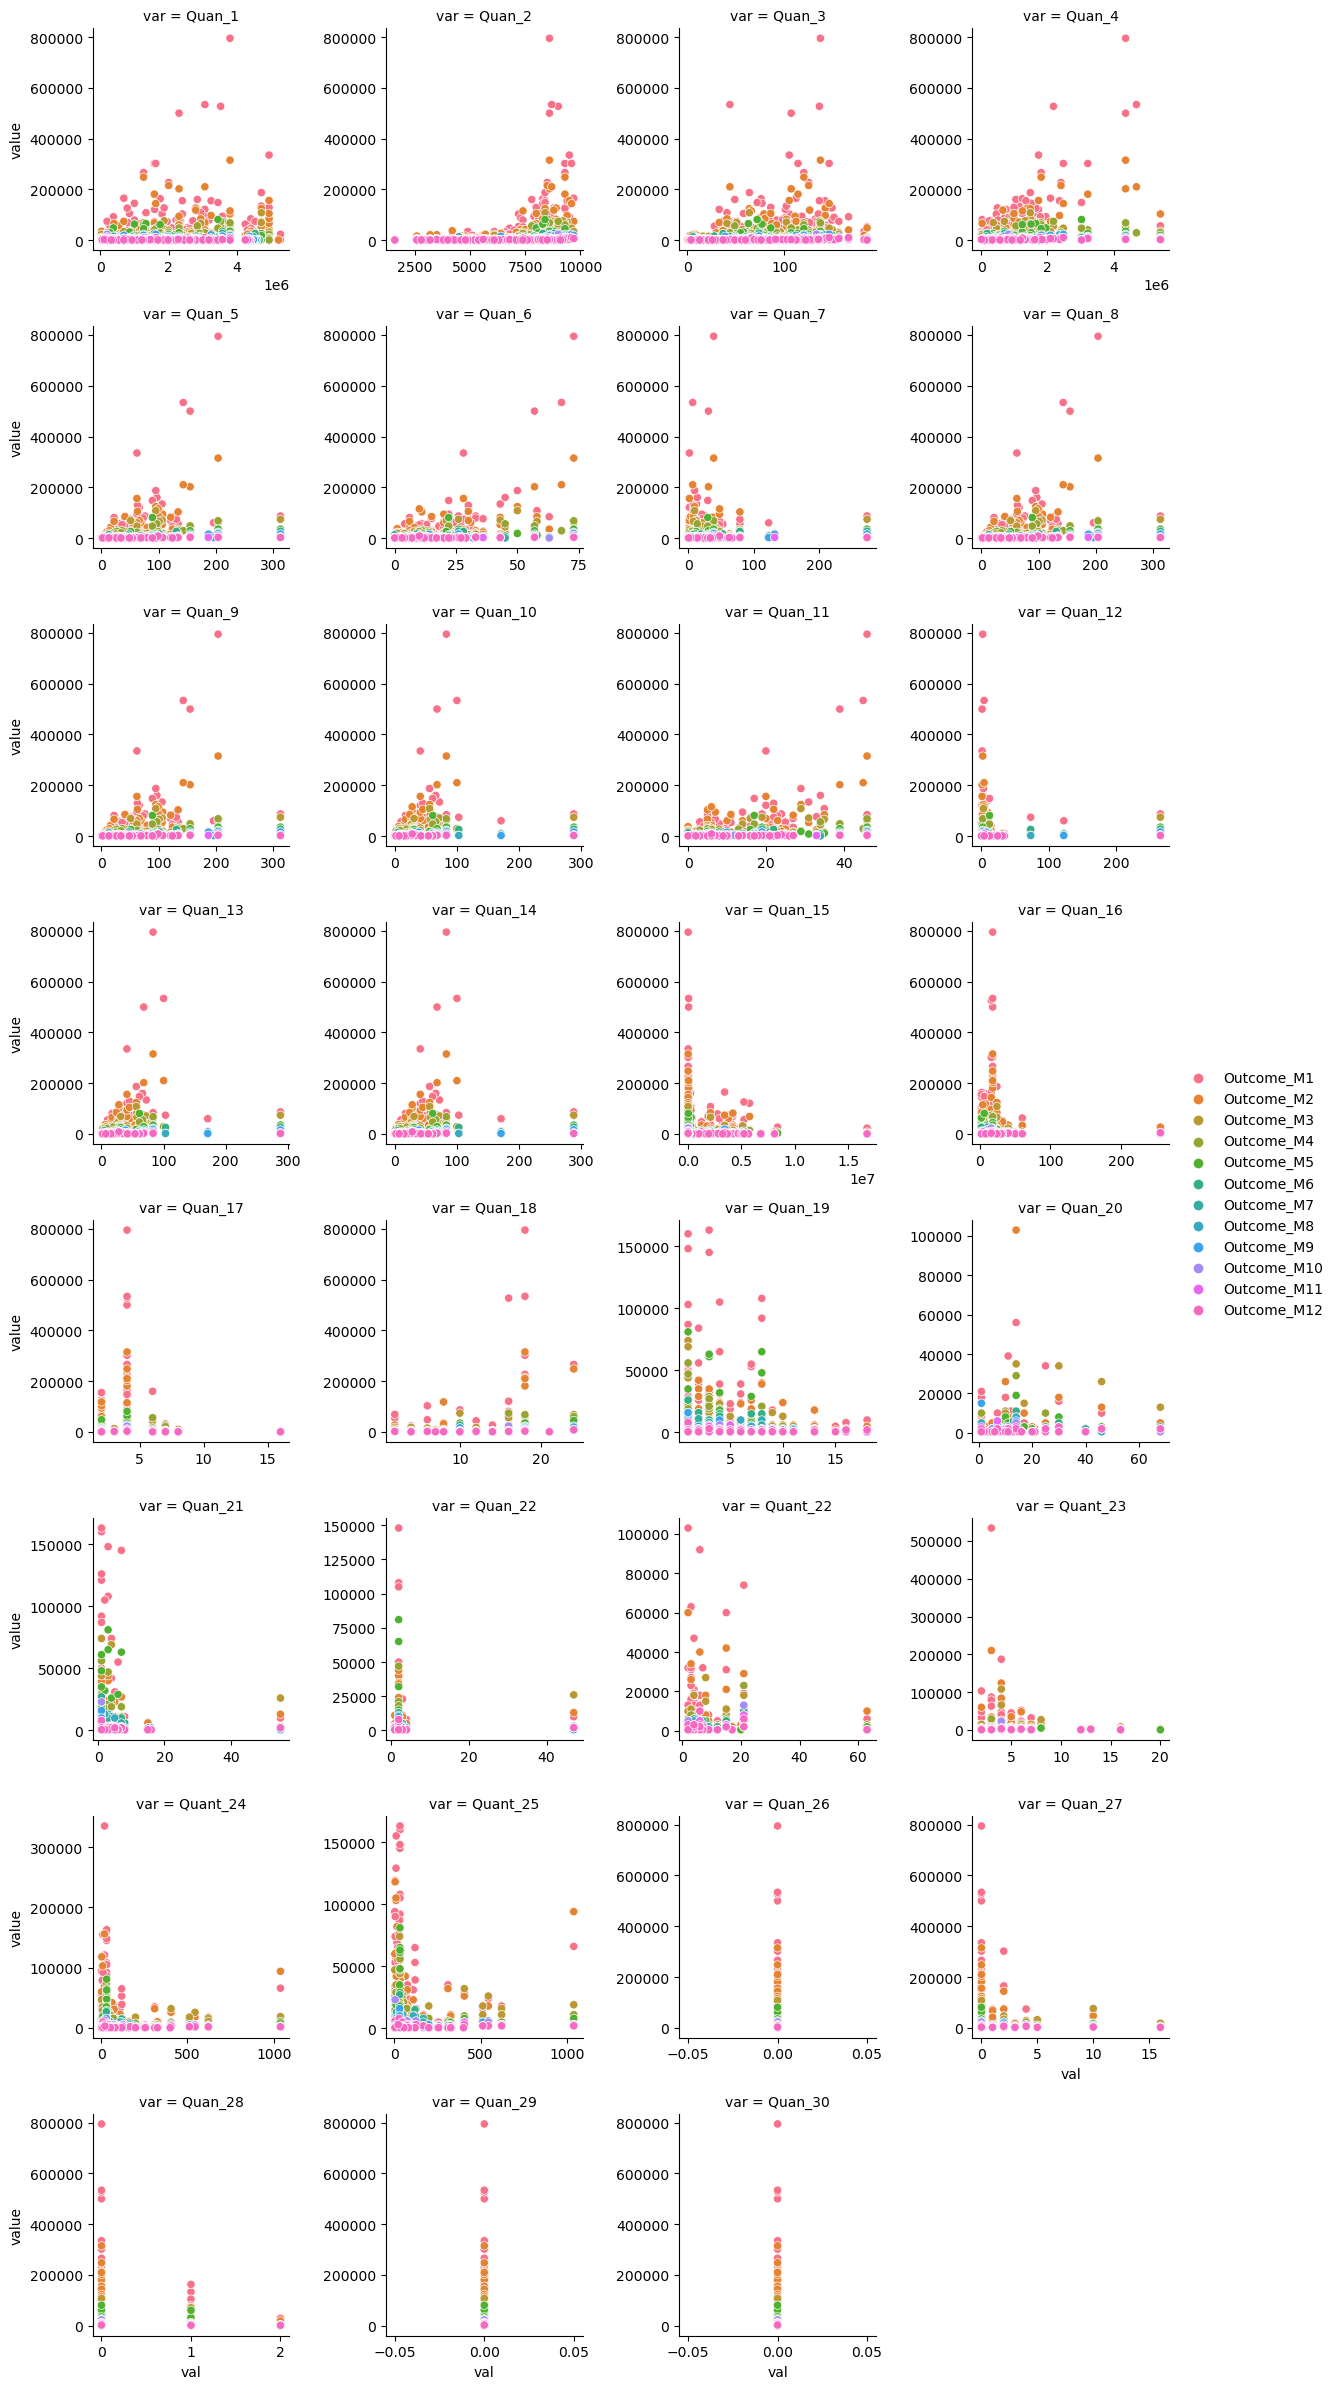

In [43]:
melted = train.melt(value_vars=quan_cols, id_vars=out_cols)
melted.columns = out_cols.tolist()+ ["var", "val"]
g = sns.FacetGrid(
    data=melted.melt(id_vars=["var","val"]),
    col="var",
    col_wrap=4,
    sharex=False,
    sharey=False
)
g.map(sns.scatterplot, "val", "value", "variable")
g.add_legend();

Above we observe the relationships between quantitative values and monthly sales. We notice that certain variables, in particular variables with constant values, have no predictive power.

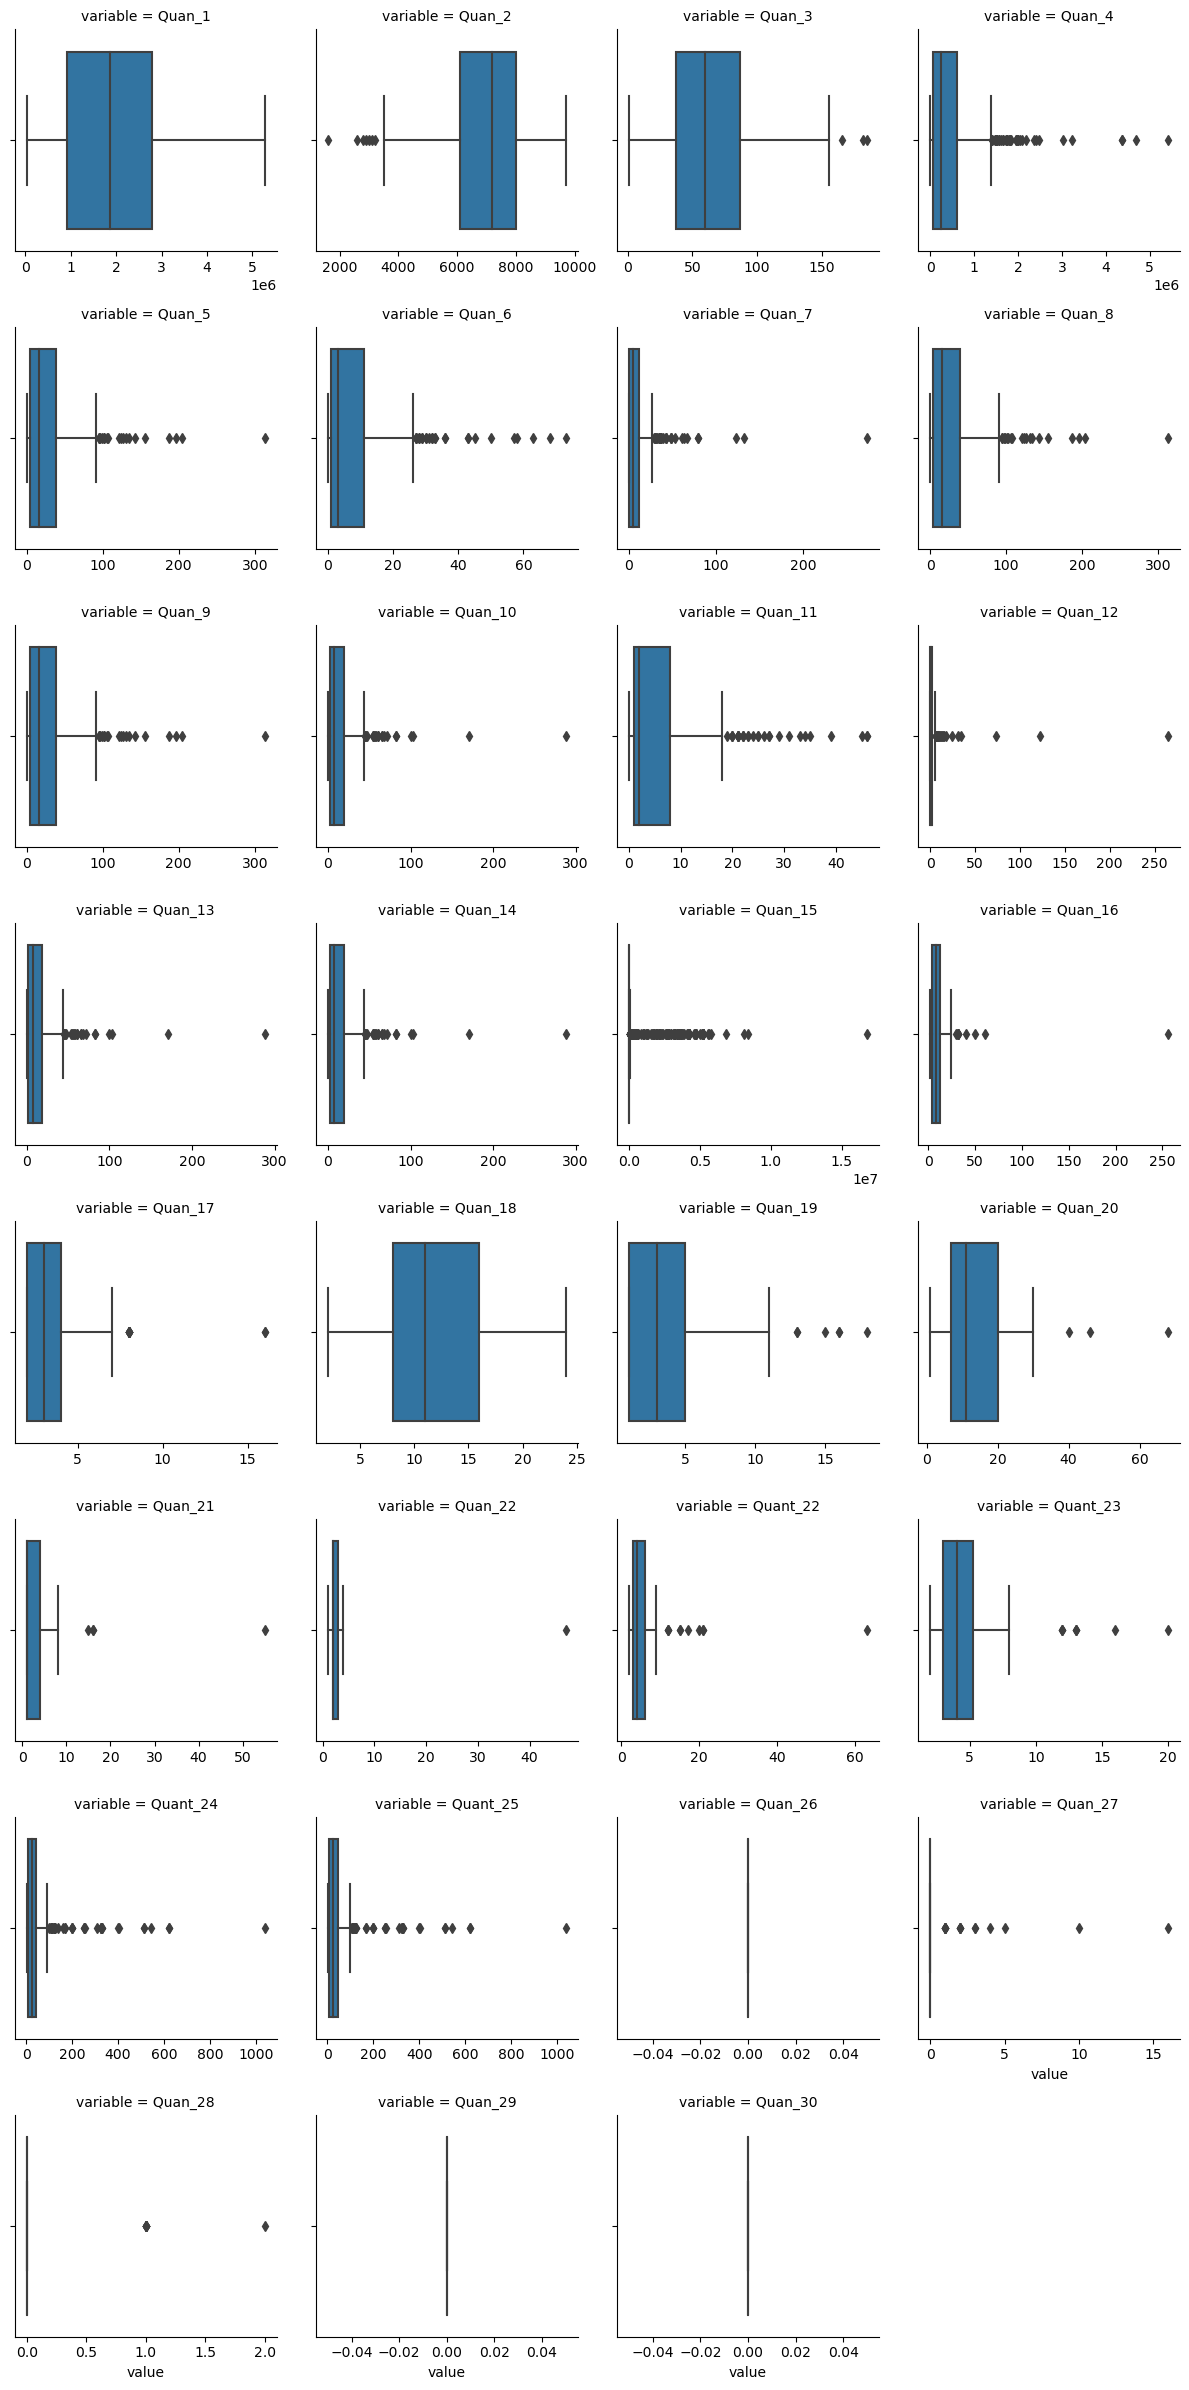

In [12]:
sns.FacetGrid(
    data=train.melt(value_vars=quan_cols),
    col="variable",
    col_wrap=4,
    sharex=False,
    sharey=False
).map(sns.boxplot, "value");

By observing the box plots of the quantitative variables, we can better highlight the outliers and we see variables with many outliers.

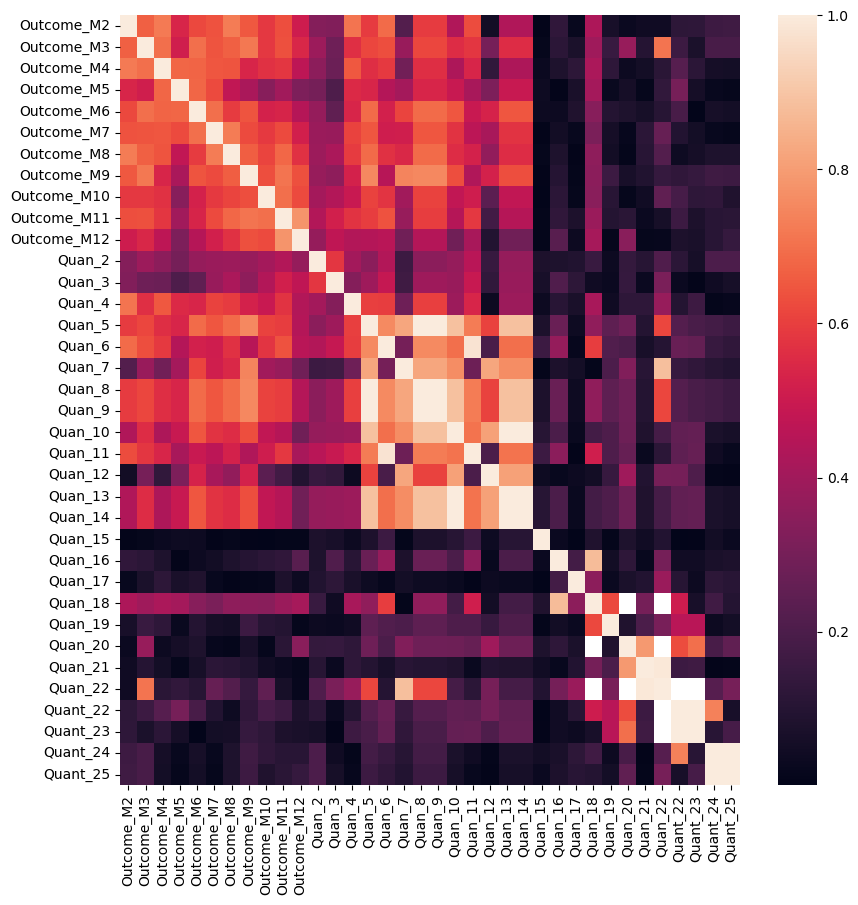

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(train.select_dtypes("float").drop(columns="Date_2").corr().abs());

Above, we can observe the correlations between the variables. We notice strong correlations between certain variables. This is shown above in lighter colors.

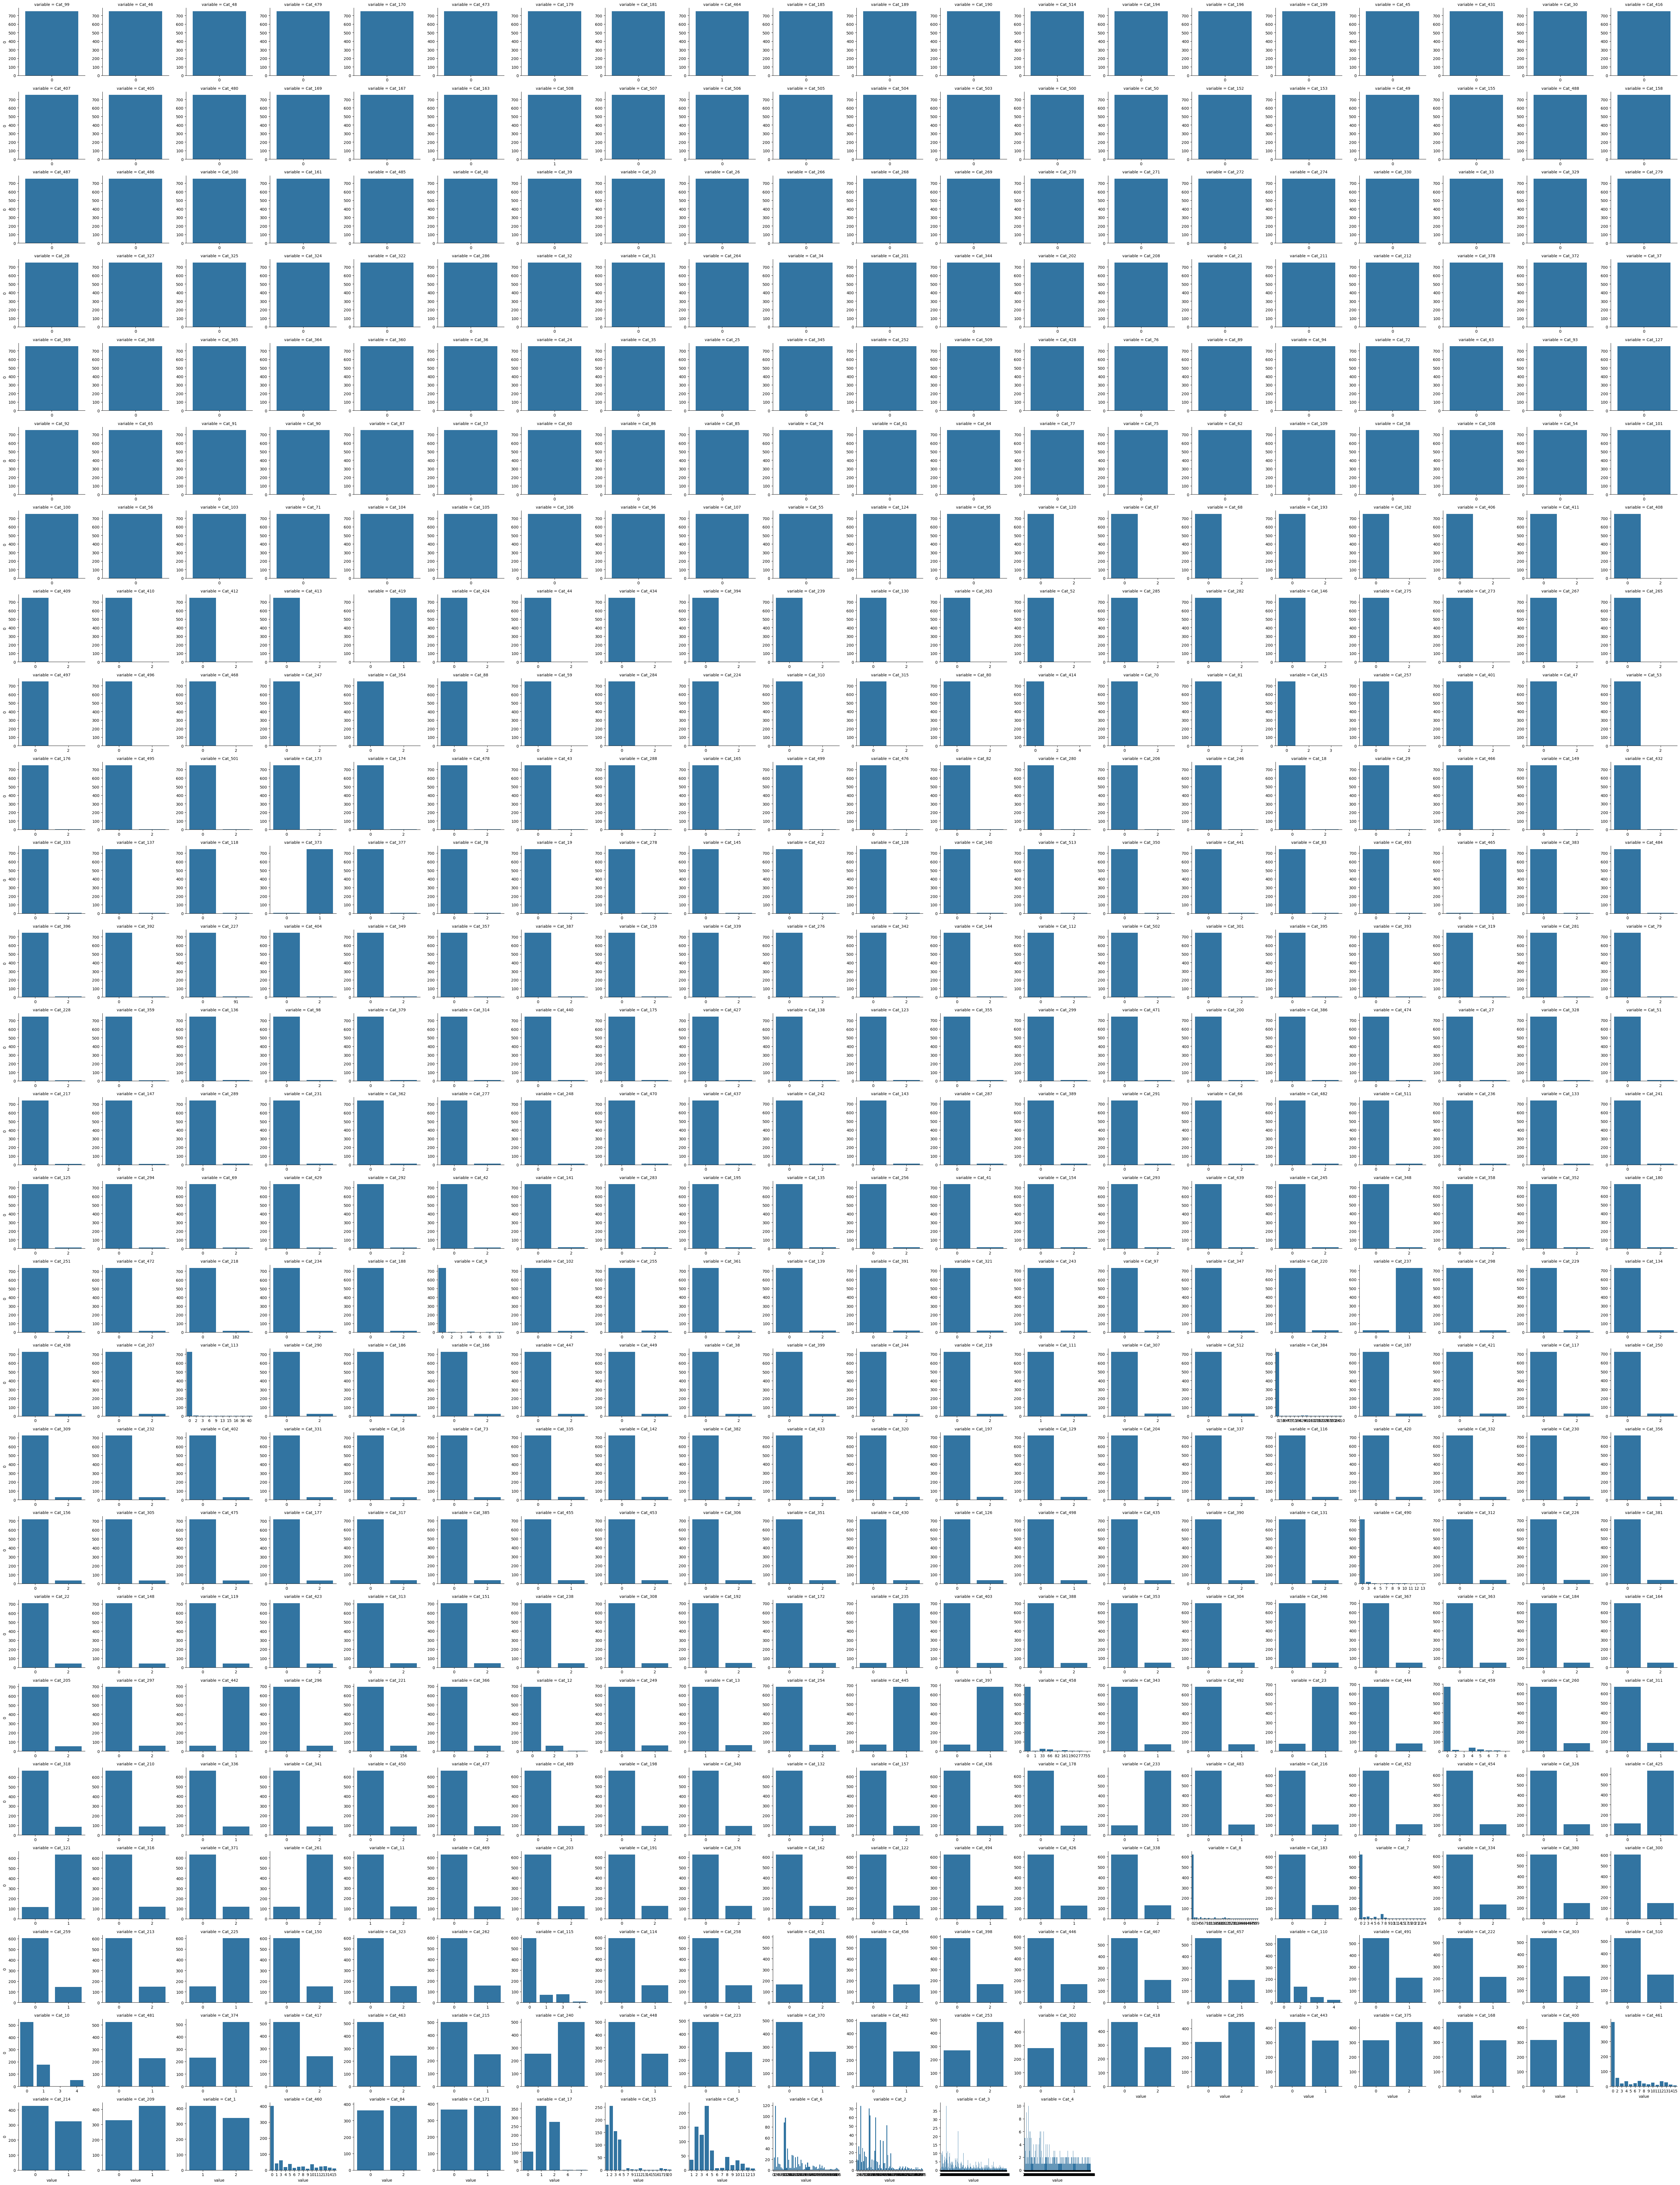

In [13]:
sns.FacetGrid(
    data=train.melt(value_vars=cat_cols).value_counts().to_frame().reset_index(),
    col="variable",
    col_wrap=20,
    sharex=False,
    sharey=False
).map(sns.barplot, "value", 0);

We observe above the frequencies of the different classes in each categorical variable. We notice that some variables have constant values as well as variables with many classes. We can also see that the distribution of classes in certain variables is strongly unbalanced. Constant variables have no predictive power, while unbalanced variables risk making predictions more in favor of the majority classes.

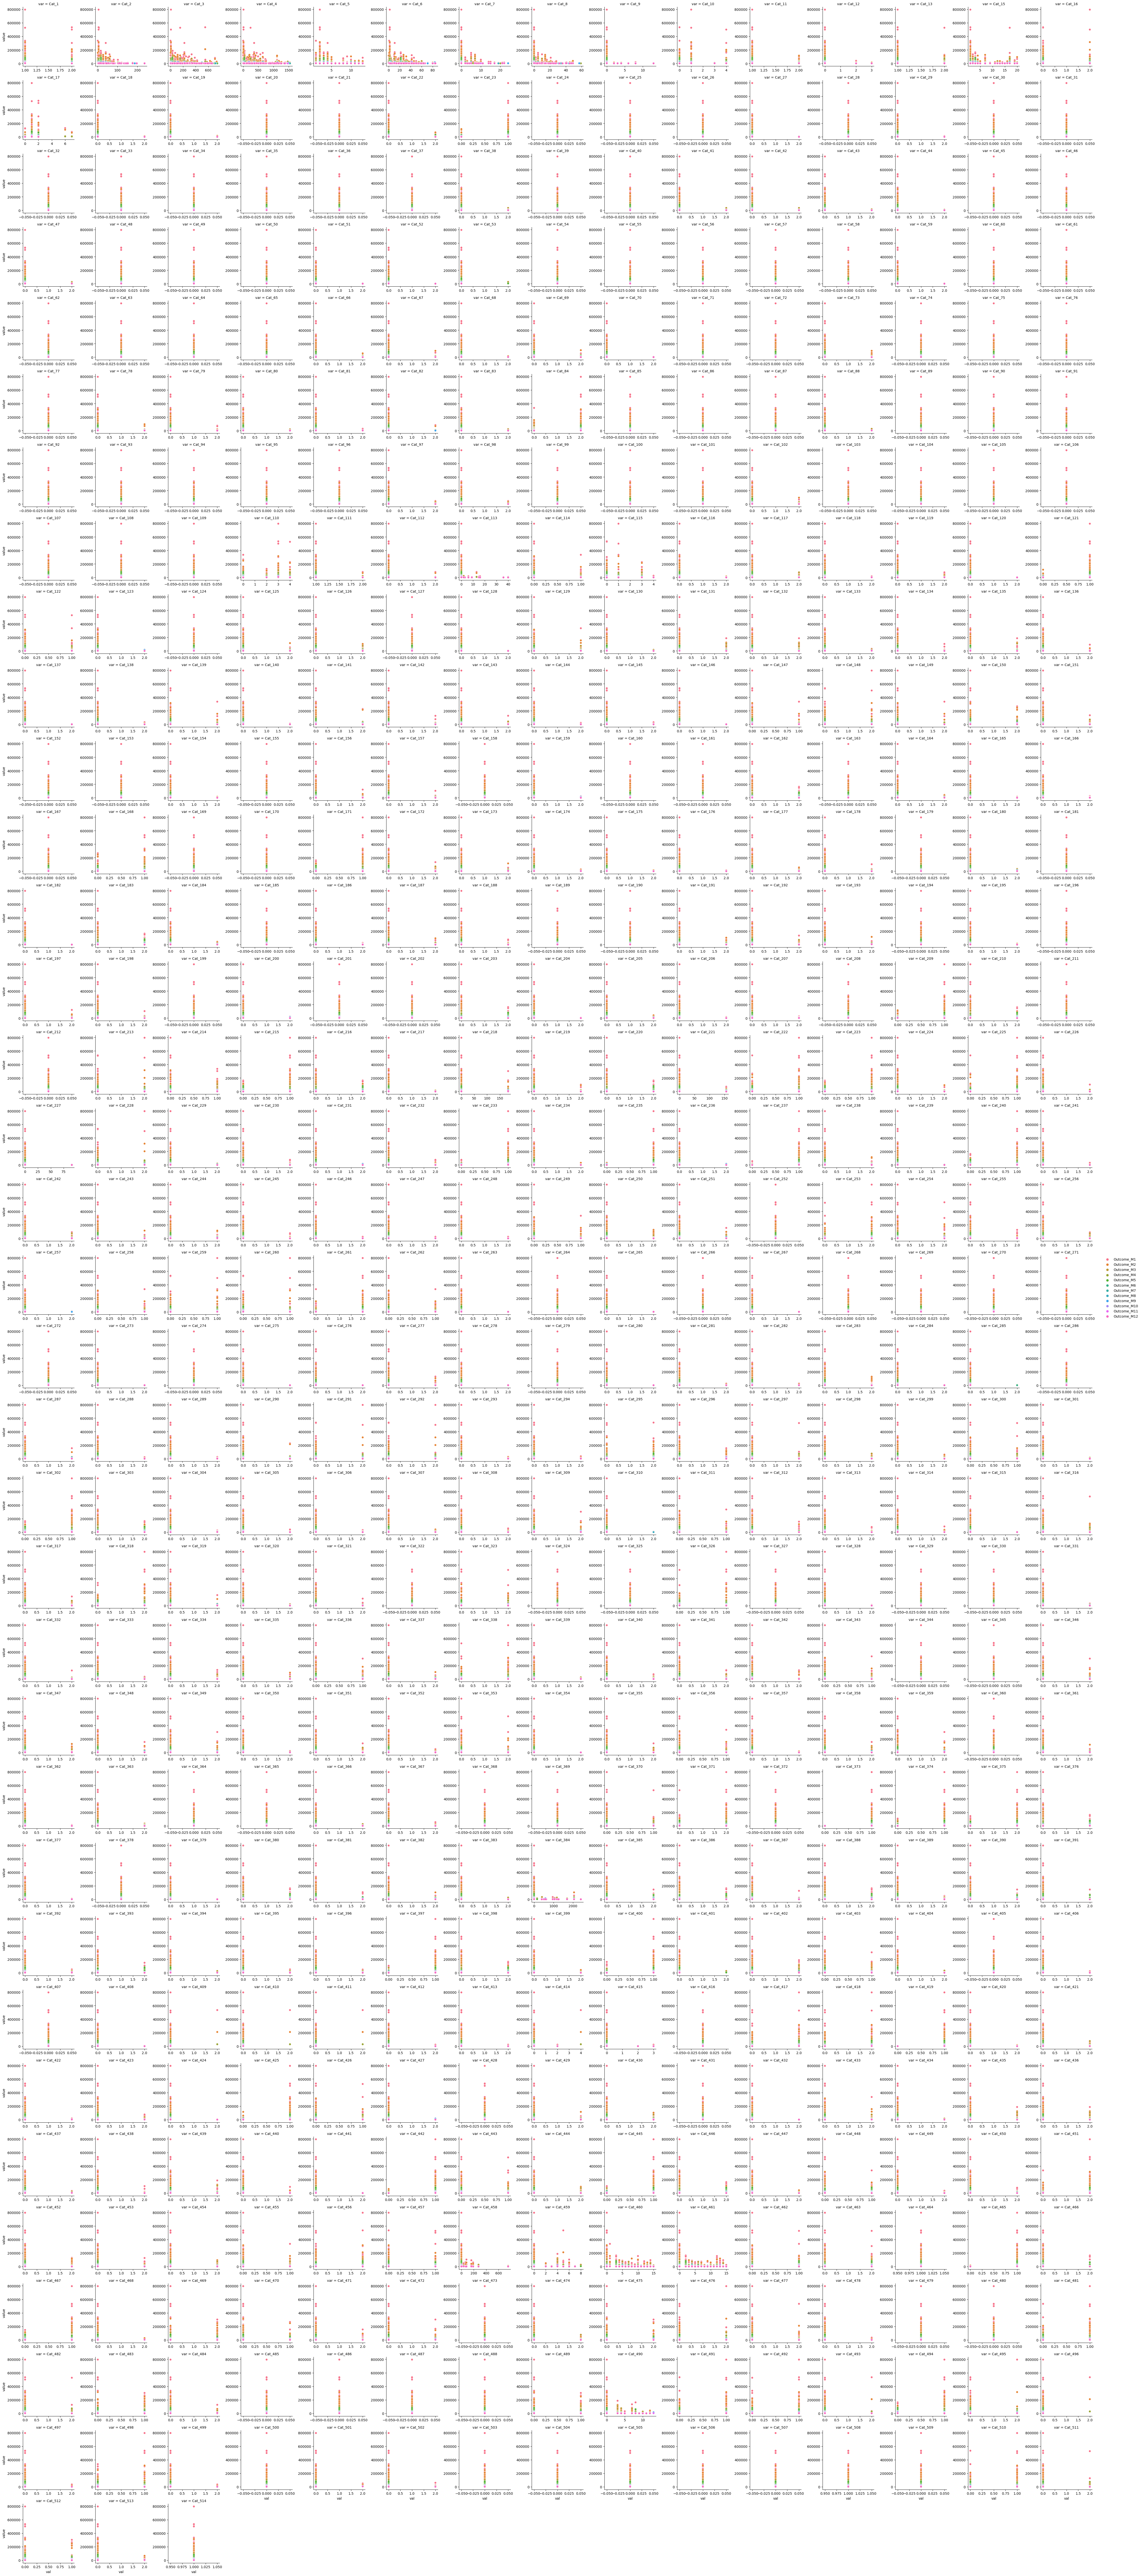

In [4]:
melted = train.melt(value_vars=cat_cols, id_vars=out_cols)
melted.columns = out_cols.tolist()+ ["var", "val"]
g = sns.FacetGrid(
    data=melted.melt(id_vars=["var","val"]),
    col="var",
    col_wrap=15,
    sharex=False,
    sharey=False
)
g.map(sns.scatterplot, "val", "value", "variable")
g.add_legend();

Above, we observe the relationships between the target variables and the quantitative variables. As previously stated, some variables have constant values and have no predictive power. Above, we observe the relationships between the target variables and the date variables.

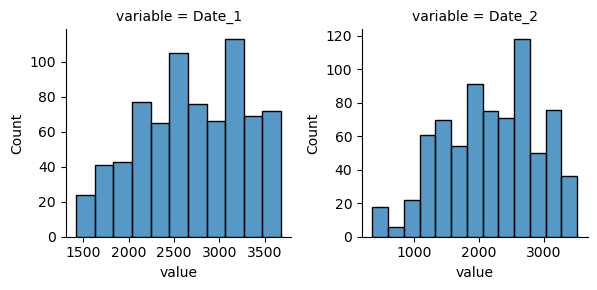

In [8]:
sns.FacetGrid(
    data=train.melt(value_vars=date_cols),
    col="variable",
    col_wrap=4,
    sharex=False,
    sharey=False
).map(sns.histplot, "value");

The dates are represented in numerical values whose distribution is observed above. We notice that the distribution is quite balanced.

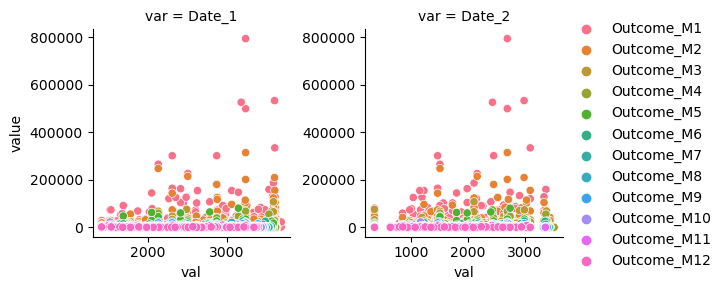

In [6]:
melted = train.melt(value_vars=date_cols, id_vars=out_cols)
melted.columns = out_cols.tolist()+ ["var", "val"]
g = sns.FacetGrid(
    data=melted.melt(id_vars=["var","val"]),
    col="var",
    sharex=False,
    sharey=False
)
g.map(sns.scatterplot, "val", "value", "variable")
g.add_legend();

Above, we observe the relationships between the target variables and the date variables.

## Modèle

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression

from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn import set_config

set_config(transform_output="pandas")

Let's start by establishing a baseline that will serve as a reference to measure the performance of our model.

In [7]:
print("RMSLE: ", mean_squared_log_error(
    train[out_cols].dropna(),
    np.zeros_like(train[out_cols].dropna()) + train[out_cols].mean(axis=0).to_list(),
    squared=False
))

RMSLE:  1.158900088460211


We saw that certain variables were unusable due to the large number of missing values they contain. Likewise, we have several constant-valued variables which have no predictive power. We're going to remove these columns. In addition, the target variables also have some missing values that must be removed in order to build our model.

In [8]:
df_train = train.dropna(subset=out_cols)

n_date_cols = date_cols
n_cat_cols = df_train[cat_cols].columns[df_train[cat_cols].nunique() > 1]
n_quan_cols = df_train[quan_cols].columns[df_train[quan_cols].nunique() > 1]
n_quan_cols = df_train[n_quan_cols].columns[df_train[n_quan_cols].isna().sum()/len(df_train) < 0.5]
cols = n_cat_cols.append(n_quan_cols).append(n_date_cols)

In [9]:
X, y = df_train.drop(columns=out_cols), df_train[out_cols]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's build several models taking the best at the end.

In [33]:
Imputer0 = make_column_transformer(
    (SimpleImputer(strategy="mean"), n_quan_cols),
    (SimpleImputer(strategy="most_frequent"), n_cat_cols.append(n_date_cols)),
    verbose_feature_names_out=False,
)

Imputer1 = make_column_transformer(
    (KNNImputer(), cols),
    verbose_feature_names_out=False,
)

In [34]:
Scaler0 = make_column_transformer(
    (StandardScaler(), n_quan_cols),
    verbose_feature_names_out=False,
    remainder="passthrough"
)

Scaler1 = make_column_transformer(
    (RobustScaler(), n_quan_cols),
    verbose_feature_names_out=False,
    remainder="passthrough"
)

Scaler2 = make_column_transformer(
    (PowerTransformer(), n_quan_cols),
    verbose_feature_names_out=False,
    remainder="passthrough"
)

In [86]:
forest_reg_0 = MultiOutputRegressor(
    Pipeline([
        ("imputer", Imputer0),
        ("scaler", Scaler0),
        ("selection", PCA()),
        ("model", RandomForestRegressor(random_state=42)),
    ])
)

forest_reg_1 = MultiOutputRegressor(
    Pipeline([
        ("imputer", Imputer1),
        ("scaler", Scaler0),
        ("selection", PCA()),
        ("model", RandomForestRegressor(random_state=42)),
    ])
)

forest_reg_2 = MultiOutputRegressor(
    Pipeline([
        ("imputer", Imputer0),
        ("scaler", Scaler1),
        ("selection", SelectKBest(score_func=mutual_info_regression)),
        ("model", RandomForestRegressor(random_state=42)),
    ])
)

forest_reg_3 = MultiOutputRegressor(
    Pipeline([
        ("imputer", Imputer1),
        ("scaler", Scaler1),
        ("selection", SelectKBest(score_func=mutual_info_regression)),
        ("model", RandomForestRegressor(random_state=42)),
    ])
)

forest_reg_4 = MultiOutputRegressor(
    Pipeline([
        ("imputer", Imputer0),
        ("scaler", Scaler2),
        ("selection", SelectKBest(score_func=mutual_info_regression)),
        ("model", RandomForestRegressor(random_state=42)),
    ])
)

forest_reg_5 = MultiOutputRegressor(
    Pipeline([
        ("imputer", Imputer1),
        ("scaler", Scaler2),
        ("selection", SelectKBest(score_func=mutual_info_regression)),
        ("model", RandomForestRegressor(random_state=42)),
    ])
)

In [87]:
params = {
    "estimator__selection__n_components": np.arange(50, 150, 20),
    "estimator__model__n_estimators": np.arange(5, 20, 5),
    "estimator__model__max_depth": np.arange(10, 30, 5),
}
    
gcv_0 = GridSearchCV(estimator=forest_reg_0, param_grid=params, n_jobs=-1)
gcv_1 = GridSearchCV(estimator=forest_reg_1, param_grid=params, n_jobs=-1)

In [88]:
params = {
    "estimator__selection__k": np.arange(50, 150, 20),
    "estimator__model__n_estimators": np.arange(5, 20, 5),
    "estimator__model__max_depth": np.arange(10, 30, 5),
}

gcv_2 = GridSearchCV(estimator=forest_reg_2, param_grid=params, n_jobs=-1)
gcv_3 = GridSearchCV(estimator=forest_reg_3, param_grid=params, n_jobs=-1)
gcv_4 = GridSearchCV(estimator=forest_reg_4, param_grid=params, n_jobs=-1)
gcv_5 = GridSearchCV(estimator=forest_reg_5, param_grid=params, n_jobs=-1)

In [90]:
gcv_0.fit(X_train, y_train)
gcv_1.fit(X_train, y_train);

In [92]:
gcv_2.fit(X_train, y_train)
gcv_3.fit(X_train, y_train);

In [ ]:
gcv_4.fit(X_train, y_train)
gcv_5.fit(X_train, y_train);

In [94]:
model = [
    gcv_0.best_estimator_,
    gcv_1.best_estimator_,
    gcv_2.best_estimator_,
    gcv_3.best_estimator_,
    gcv_4.best_estimator_,
    gcv_5.best_estimator_,
]

In [95]:
for i in range(6):
    print("RMSLE_", i, ": ", mean_squared_log_error(
        y_test,
        model[i].predict(X_test),
        squared=False
    ))

RMSLE_ 0 :  0.8973255567220438
RMSLE_ 1 :  0.9021854256376627
RMSLE_ 2 :  0.7442268216798035
RMSLE_ 3 :  0.7493693835110852


Of all the models tested, model 2 is the most efficient.

---